<a href="https://colab.research.google.com/github/nurcse/MachineLearning/blob/master/House_Prices_Advanced_Regression_Techniques_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ID : A1811
Date : 10-02-2019

# Summary

To solve the House Price kaggle challenge first I look into data, pre processed them and design, train a neural net model then submitted output to kaggle to check performance of my model.


*   First I split numerical and categorical features, as they require to be processed separately. Then I split numerical features into contunous and discrete features. There are 43 categorical, 38 numerical features. In numerical features 15 are discrete and 21 are contunous.
*   Then I look into how many features have missing or null values and how many from each categories. 19 features have null values. For pre-processing I combined train and test data together, so that I wouldn't get error in test data calculation. Then I fill up null values individually from each categories. Some with mean, some with meadian, some with most frequent values...
*   I tried to see skewness of contunous features and saw that most of them are skewed and not normally distributed. To tackle this problem I used box cox transformation. 
*   I splitted categorical features in two categories(Ordinal and nominal) based on information of data description file and intuition. Then Label encoded Ordinal categories and One Hot encoded nominal categories.
*   Finally for feature scaling I used MinMaxScaler from scikit learn.
*   Then I designed Deep Neural Network model and train that model with engineered and scaled feature values. then tested that model with test data and evaluated on kaggle. I tweaked hyper parameters and redesigned neural net. model with different number of layers and neurons as well for better performance. On last part of this notebook I showed different model configuration and performance on kaggle and on training set.

```
# This is formatted as code
```

 



In [0]:
"""
    import statements
"""
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr

import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.ion
"""
    =================================
"""

'\n    =================================\n'

In [0]:
"""
    For uploading file in google colab environment.
    
    Below i'm uploading training .csv file for house price problem
"""
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
"""
    Reading the training file in a pandas Dataframe.
"""
import io
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
#print(train_df.head())
print('#of columns :', len(train_df.columns), '| #of rows :', len(train_df))

#of columns : 81 | #of rows : 1460


# Feature Engineering and Data Pre-processing

Wee see that the data contains 81 features or columns, definitely one will be target or label.
First we will see how many features contain null value or have missing data on rows. Beacause if any column contain null value
we need to process them before any type of calculation otherwise it will give error or code won't run at all. How  will we  fill those null values is the next question and it actually requires some statistical analysis and insights of data. In the following sections I will try to do something like that. 

In [0]:
# printing number of colums with missing data
null_count = 0
for col in train_df.columns:
  if train_df[col].isnull().sum()>0:
      null_count += 1
print('#of columns having missing value', null_count)

#of columns having missing value 19


In [0]:
"""
    Now we will see which features contains null value and how many null value they contains
"""

null_values = train_df.isnull().sum()

null_values[null_values>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [0]:
"""
    We see that some features having so many null values. If we want to tell this in numbers we can try to see 
    how many columns have null values more than 80 percent.
""" 

for col in train_df.columns:
    if train_df[col].isnull().mean() > 0.80:
        if(train_df[col].dtype == 'O'):
            print(col, train_df[col].unique(), ': feature type is object')
        else:
            print(col, train_df[col].unique(), ': feature type is numeric')


Alley [nan 'Grvl' 'Pave'] : feature type is object
PoolQC [nan 'Ex' 'Fa' 'Gd'] : feature type is object
Fence [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] : feature type is object
MiscFeature [nan 'Shed' 'Gar2' 'Othr' 'TenC'] : feature type is object


So, there are 4 features/columns having more than 80 percent of null values and the type of all of them is object. 
    Now we will see what are these columns description says. In the feature 'Alley' NA means No Alley Access, in 'PoolQC' NA means No Pool,
    in 'Fence' NA means no No Fence and in 'MiscFeature' NA means None. So as they are object type columns and they have specific meaning
    in null values we need to fill up those further.
    In next few sections we will see how many features are categorical and how many are numerical, within that we will also see how many numerical features can be treated as discrete feature.

In [0]:
# categorical features
categorical = [col for col in train_df.columns if train_df[col].dtype=='O']
print('There are :',len(categorical), 'categorical columns')

There are : 43 categorical columns


In [0]:
# numerical features
numerical = [col for col in train_df.columns if train_df[col].dtype!='O']
print('There are :',len(numerical), 'numerical columns')

There are : 38 numerical columns


In [0]:
"""
    let's visualise the values of the discrete features, I consider 15 as a threshhold for unique values to consider a feature as
    discrete feature, the choice of 15 was a random. 
"""
discrete = []
for col in numerical:
    if len(train_df[col].unique()) <= 15:
        print(col, ' values: ', train_df[col].unique())
        discrete.append(col)
        
print('There are :',len(discrete), 'discrete variables')

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are : 15 discrete variables


In [0]:
# now we will make a list of continuous features (from the numerical ones)
continuous = [col for col in numerical if col not in discrete and col not in ['Id', 'SalePrice']]
print('#of continuous columns :', len(continuous),'\n', continuous)

#of continuous columns : 21 
 ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


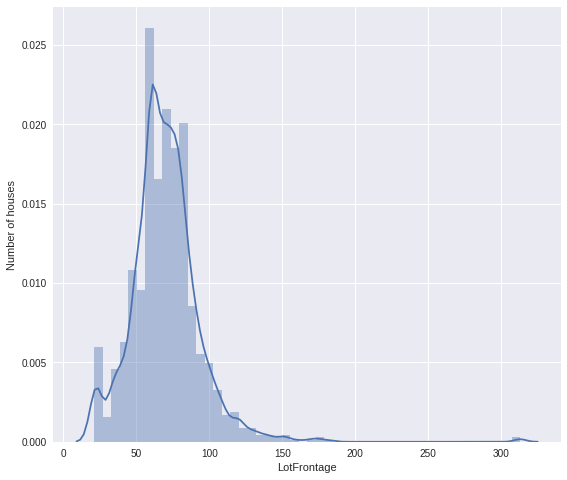

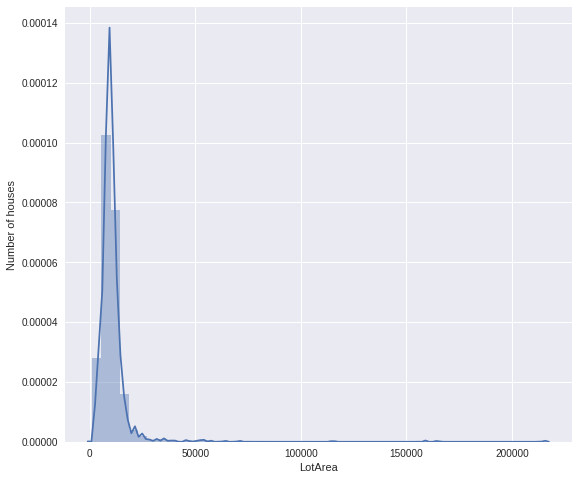

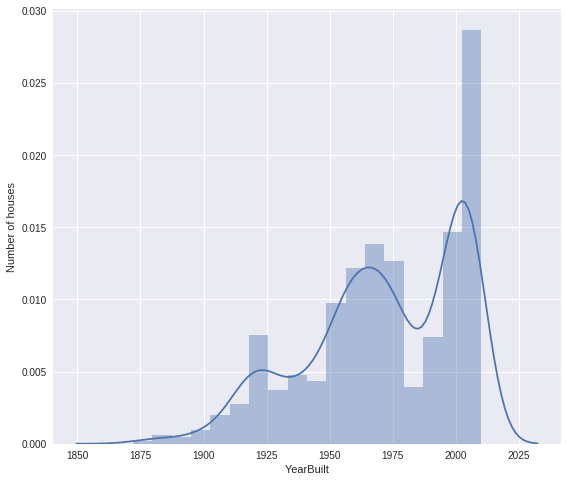

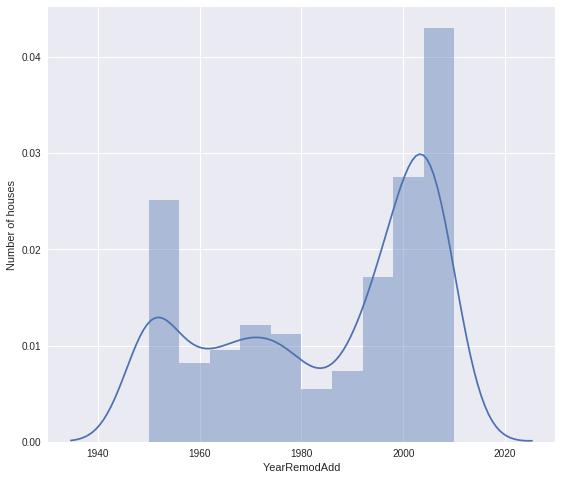

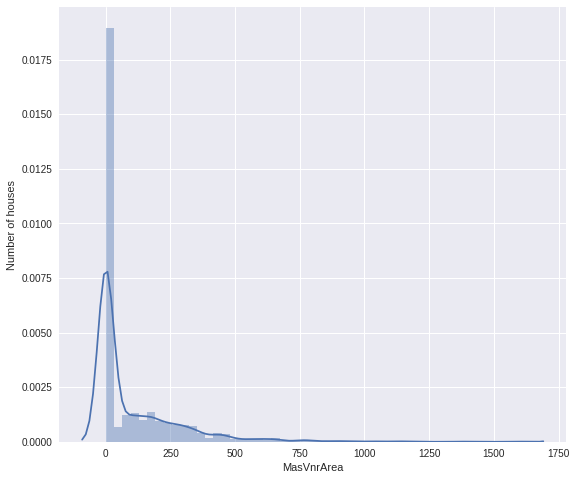

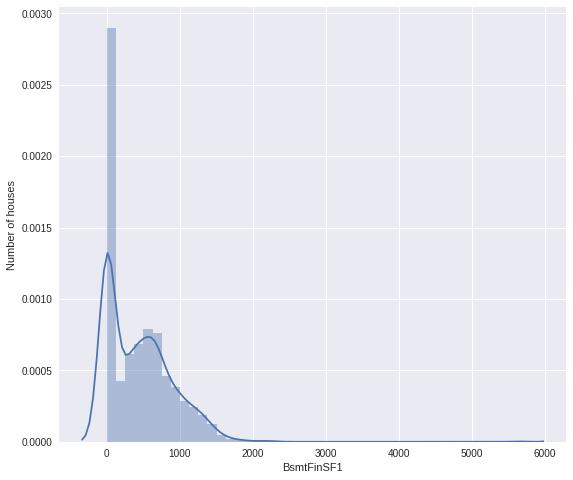

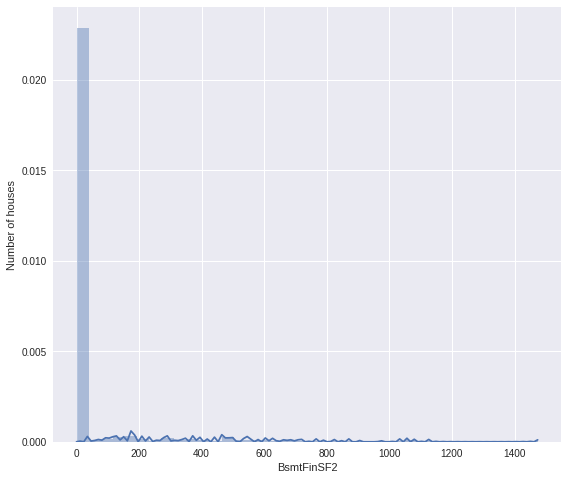

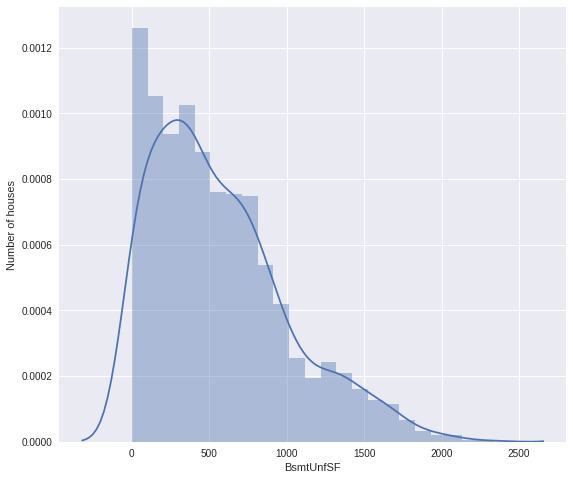

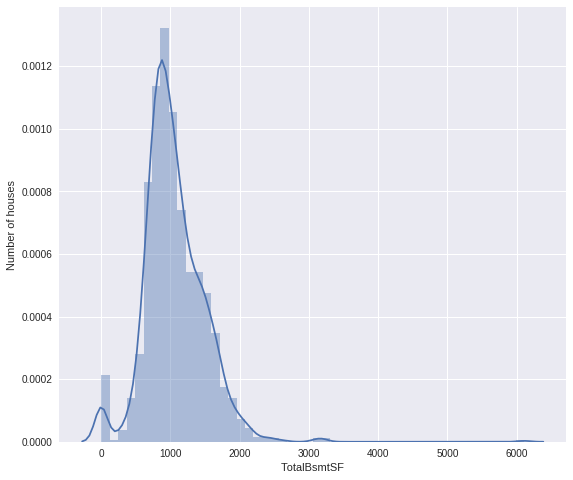

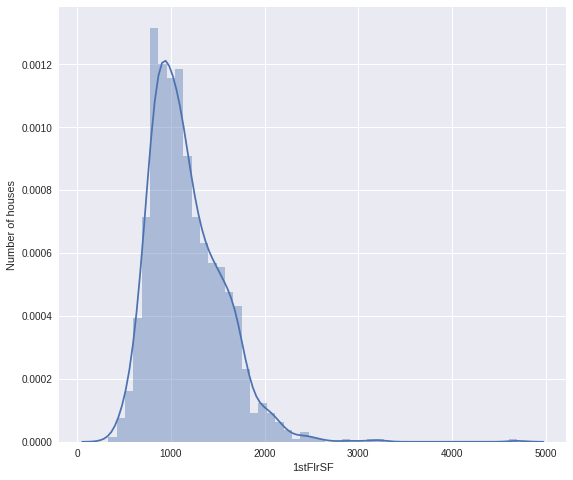

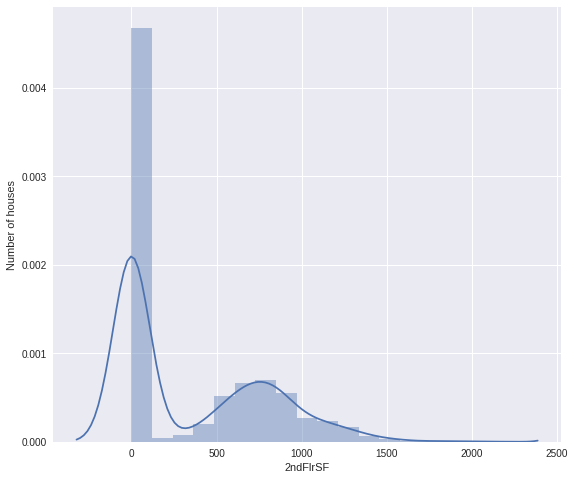

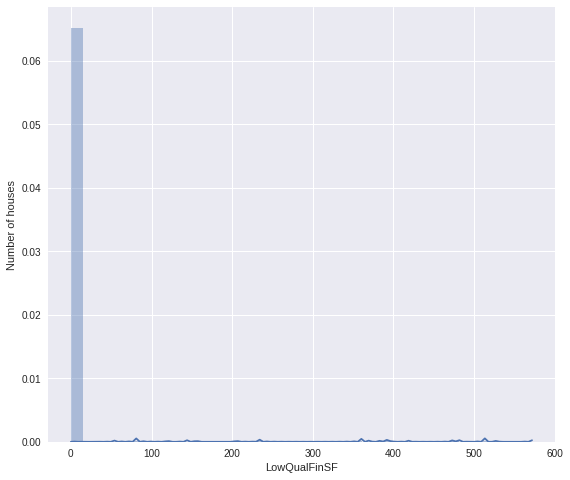

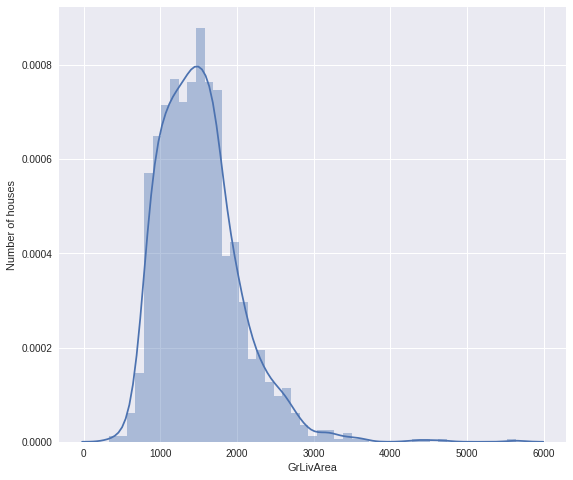

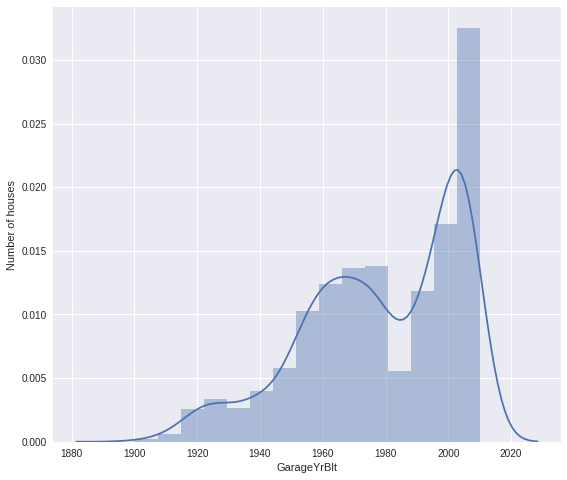

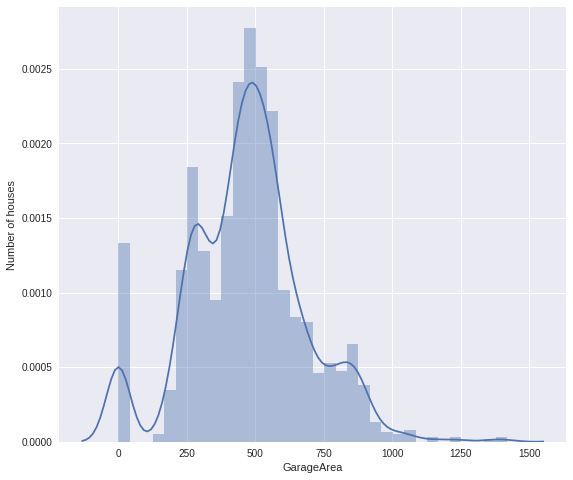

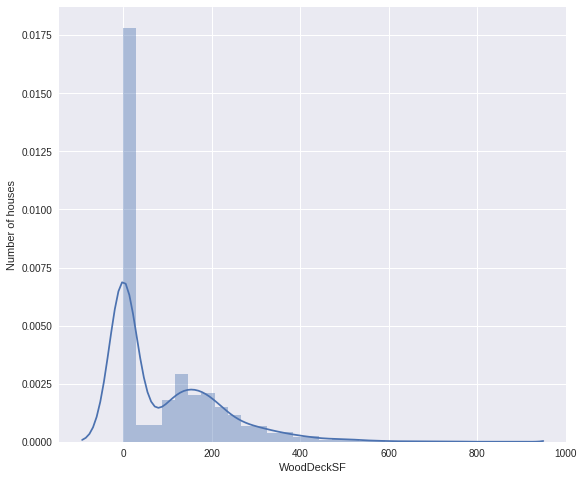

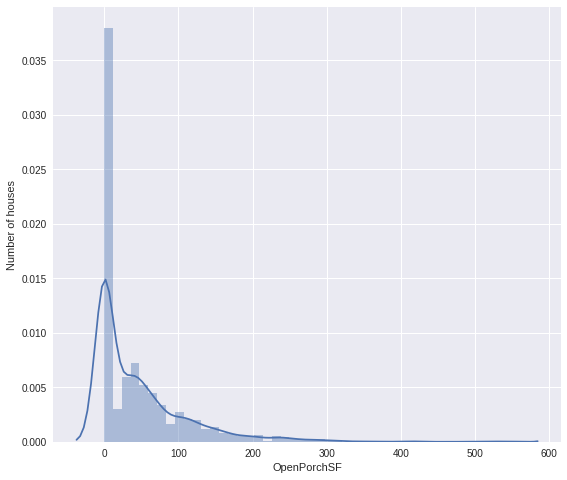

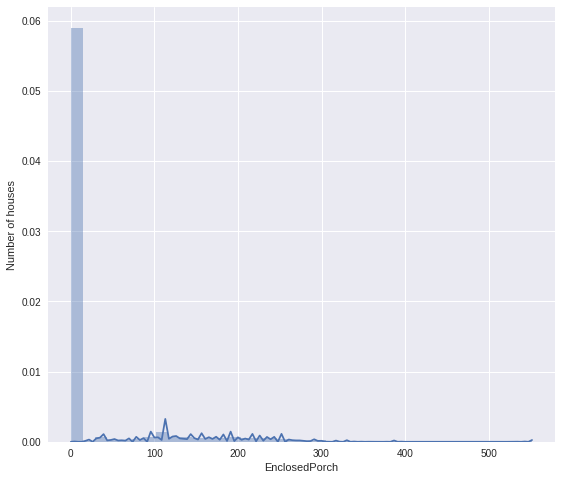

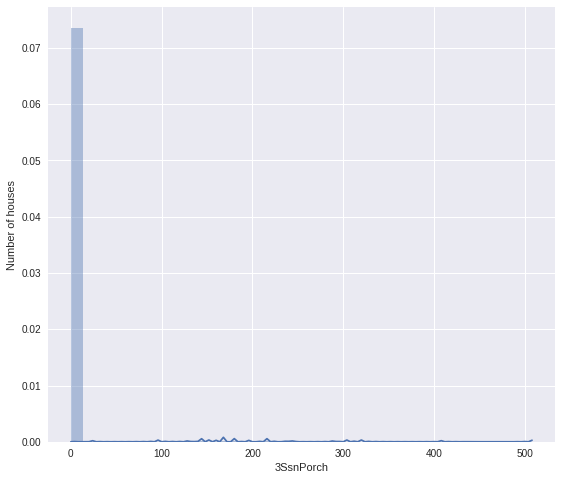

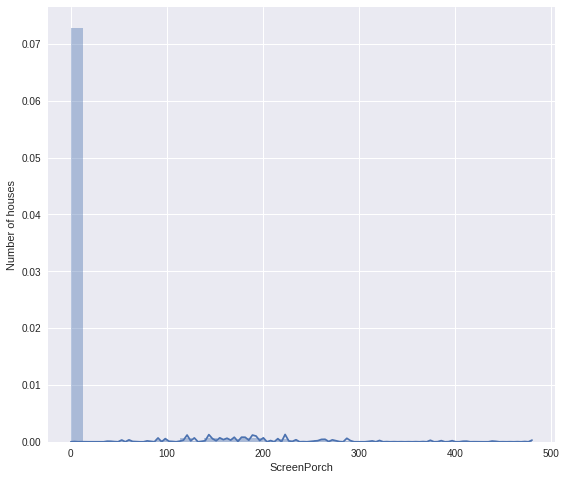

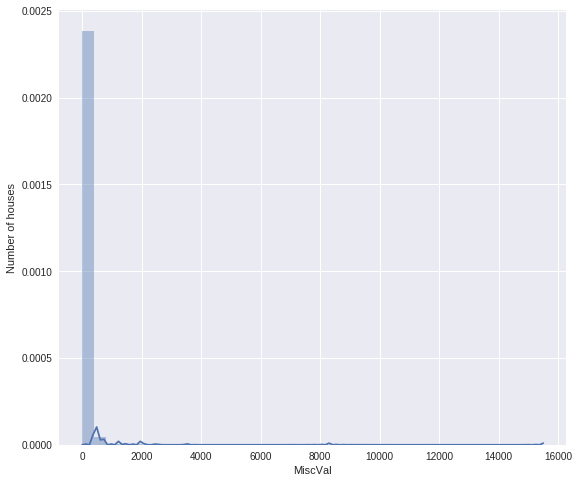

In [0]:
# let's make histograms to get an idea of the distribution of the continuous features

for col in continuous:
    plt.figure(figsize=(20,8))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(train_df[col].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(col)

    plt.show()

From the graph we see that the majority of the continuous features are not normally distributed. We are trying to build a regression model for this problem,  as it is a regression model we need to handle this skewed features for better performance of the model. I will transform the features with a box cox from scipy to make them more 'Gaussian' looking next.

In [0]:
"""
    Now we will check categorical features if they contain large number of unique categories. This is called 
    high cardinality, high cardinality affects performance of some machine learning model. 
"""

for col in categorical:
  print(col, ' contains #of unique labels :', len(train_df[col].unique()))

MSZoning  contains #of unique labels : 5
Street  contains #of unique labels : 2
Alley  contains #of unique labels : 3
LotShape  contains #of unique labels : 4
LandContour  contains #of unique labels : 4
Utilities  contains #of unique labels : 2
LotConfig  contains #of unique labels : 5
LandSlope  contains #of unique labels : 3
Neighborhood  contains #of unique labels : 25
Condition1  contains #of unique labels : 9
Condition2  contains #of unique labels : 8
BldgType  contains #of unique labels : 5
HouseStyle  contains #of unique labels : 8
RoofStyle  contains #of unique labels : 6
RoofMatl  contains #of unique labels : 8
Exterior1st  contains #of unique labels : 15
Exterior2nd  contains #of unique labels : 16
MasVnrType  contains #of unique labels : 5
ExterQual  contains #of unique labels : 4
ExterCond  contains #of unique labels : 5
Foundation  contains #of unique labels : 6
BsmtQual  contains #of unique labels : 5
BsmtCond  contains #of unique labels : 5
BsmtExposure  contains #of uni

From the output we see that most of the features contain only a few number of unique values. So we do not have to deal with high cardinality, this is a good news. In next cell we will upload test file and will read as Dataframe. As test file may contain null values, we need to process them also as we will test out model on test data and will submit on kaggle.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
import io
test_df = pd.read_csv(io.BytesIO(uploaded['test.csv']))
print('#of columns :', len(test_df.columns), '| #of rows :', len(test_df))

#of columns : 80 | #of rows : 1459


In test file there are 80 features and 1459 rows. Next we will combine train and test data for null value handling and feature engineering and before that we will separate the target of train data.

In [0]:
y_train_df = train_df.SalePrice
y_train_df.count()

1460

In [0]:
# concatenate the train and test data

nOftrainSample = train_df.shape[0]
nOftestSample = test_df.shape[0]

train_df_withoutTarget = train_df.drop(['SalePrice'], axis=1, inplace=False) 

all_data_df = pd.concat((train_df_withoutTarget, test_df)).reset_index(drop=True)

print('all_data_df size is : {}'.format(all_data_df.shape))
all_data_df.head()

all_data_df size is : (2919, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [0]:
"""
    [DATA PROCESSING]
    
    Handling null valued data in continuous features
"""

# print continuous features with missing data
for col in continuous:
  if all_data_df[col].isnull().mean()>0:
      print(col, all_data_df[col].isnull().mean())

LotFrontage 0.16649537512846865
MasVnrArea 0.0078794107571086
BsmtFinSF1 0.00034258307639602604
BsmtFinSF2 0.00034258307639602604
BsmtUnfSF 0.00034258307639602604
TotalBsmtSF 0.00034258307639602604
GarageYrBlt 0.05447070914696814
GarageArea 0.00034258307639602604


In [0]:
""" 
    |LotFrontage: Linear feet of street connected to property| features null value fill by the median of all neighborhood 
    because it's like that they have same lot frontage
"""

all_data_df["LotFrontage"] = all_data_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))  
all_data_df["LotFrontage"].isnull().sum()

0

In [0]:
"""
    From the description file we see that in 'MasVnrArea : Masonry veneer area in square feet' feature NA means no masonry veneer in 
    'MasVnrArea'. so we fill up null values with 0
""" 

all_data_df["MasVnrArea"] = all_data_df["MasVnrArea"].fillna(0) 
all_data_df["MasVnrArea"].isnull().sum()

0

In [0]:
""" 
    For the below 5 numeric features(BsmtFinSF1: Type 1 finished square feet, BsmtFinSF2: Type 2 finished square feet, 
    BsmtUnfSF: Unfinished square feet of basement area, TotalBsmtSF: Total square feet of basement area, GarageArea: Size 
    of garage in square feet) I choose to fill up null values with the mean of each features. It was just an intuitive 
    random choice from data description and from their continuous property
""" 

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'GarageArea'):
  all_data_df[col] = all_data_df[col].interpolate().dropna()

In [0]:
"""
    'GarageYrBlt: Year garage was built' filling null values with median value.
"""

all_data_df["GarageYrBlt"].fillna(all_data_df["GarageYrBlt"].median(), inplace=True)

"""
    Handling of null value for continuous features done.
    ===================================
"""

'\n    Handling of null value for continuous features done.\n    ===================================\n'

In [0]:
"""
    [DATA PROCESSING]
    
    Handling null valued data in discrete features
"""

# print discrete features with null data

for col in discrete:
    if all_data_df[col].isnull().mean()>0:
        print(col, all_data_df[col].isnull().mean())
        print(all_data_df[col].value_counts())

BsmtFullBath 0.0006851661527920521
0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64
BsmtHalfBath 0.0006851661527920521
0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64
GarageCars 0.00034258307639602604
2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: GarageCars, dtype: int64


In [0]:
"""
    Features 'BsmtFullBath: Basement full bathrooms' and 'BsmtHalfBath: Basement half bathrooms' having 0 in most the samples.
    I choose to filling null values with 0

"""

for col in ('BsmtFullBath', 'BsmtHalfBath'):
  all_data_df[col] = all_data_df[col].fillna(0)

In [0]:
# 'GarageCars: Size of garage in car capacity' filling with median value

all_data_df["GarageCars"] = all_data_df["GarageCars"].transform(lambda x: x.fillna(x.median())) 

"""
    Handling of null value for discrete features done.
    ===================================
"""

In [0]:
"""
    [DATA PROCESSING]
    
    Handling null valued data in categorical features
"""

categorical_feature_contains_null = all_data_df[categorical].isnull().sum()

categorical_feature_contains_null[categorical_feature_contains_null>0].sort_values(ascending = False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
SaleType           1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64

In [0]:
"""
    We have disscussed about top 4 features previously. First we will fill those out.
"""

#data description says NA means "No Pool". That make sense, majority of houses have no Pool.
all_data_df["PoolQC"] = all_data_df["PoolQC"].fillna("None") 

#data description says NA means "no alley access"
all_data_df["Alley"] = all_data_df["Alley"].fillna("None") 

#data description says NA means "no fence"
all_data_df["Fence"] = all_data_df["Fence"].fillna("None") 

#data description says NA means "no misc feature"
all_data_df["MiscFeature"] = all_data_df["MiscFeature"].fillna("None") 

In [0]:
#From data description NA means "no fireplace"
all_data_df["FireplaceQu"] = all_data_df["FireplaceQu"].fillna("None") 

#From data description NA means there is no Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data_df[col] = all_data_df[col].fillna('None')
  
#From data description NA means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data_df[col] = all_data_df[col].fillna('None') 

In [0]:
# showing unique lables with the count of the feature 'MasVnrType'

all_data_df["MasVnrType"].value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

In [0]:
"""
    We see that 'MasVnrType' has four unique labels and maximum label is None, that means they have no.
    Masonry veneer. So we can fill null values with None.
"""

all_data_df["MasVnrType"] = all_data_df["MasVnrType"].fillna("None") 

In [0]:
# showing unique lables with the count of the feature 'MSZoning'

all_data_df["MSZoning"].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [0]:
"""
    'MSZoning' feature has five unique labels. We can fill null values with maximum frequent value.
"""

all_data_df['MSZoning'] = all_data_df['MSZoning'].fillna(all_data_df['MSZoning'].mode()[0])


In [0]:
# showing unique lables with the count of the feature 'Utilities'

all_data_df["Utilities"].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [0]:
"""
    As utilities has almost all samples same value without only 1 sample and only 2 null values, 
    this won't help us in training, we can drop this feature.
"""

all_data_df = all_data_df.drop(['Utilities'], axis=1)
categorical.remove('Utilities')

In [0]:
#data description says NA means typical for 'Functional' feature
all_data_df["Functional"] = all_data_df["Functional"].fillna("Typ")

In [0]:
all_data_df["Electrical"].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [0]:
#Feature 'Electrical' has one NA value. Since this feature has mostly 'SBrkr', we can set that for the null value.
all_data_df['Electrical'] = all_data_df['Electrical'].fillna(all_data_df['Electrical'].mode()[0]) 

In [0]:
all_data_df["KitchenQual"].value_counts()

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

In [0]:
#Only one NA value, we set 'TA' (which is the most frequent) for the null value in KitchenQual
all_data_df['KitchenQual'] = all_data_df['KitchenQual'].fillna(all_data_df['KitchenQual'].mode()[0])

In [0]:
all_data_df["Exterior1st"].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

In [0]:
#Again 'Exterior1st' has only one null value. We will just fill with the most frequent value
all_data_df['Exterior1st'] = all_data_df['Exterior1st'].fillna(all_data_df['Exterior1st'].mode()[0])

In [0]:
all_data_df["Exterior2nd"].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [0]:
#'Exterior2nd' also has only one null value. We will just substitute in the most common string
all_data_df['Exterior2nd'] = all_data_df['Exterior2nd'].fillna(all_data_df['Exterior2nd'].mode()[0]) 

In [0]:
all_data_df["SaleType"].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [0]:
#Fill in again with most frequent which is "WD"
all_data_df['SaleType'] = all_data_df['SaleType'].fillna(all_data_df['SaleType'].mode()[0]) 

"""
    Handling of null value for categorical features done.
    ===================================
"""

In [0]:
# checking if any feature contains null value

null_values = all_data_df.isnull().sum()

null_values[null_values>0].sort_values(ascending = False)

Series([], dtype: int64)

In [0]:
"""
    Previously we have seen that Most of the numeric features are not normally distributed. To tackle this problem
    I will use box cox transformation function from scipy.
"""

for col in continuous:
  all_data_df[col], param = stats.boxcox(all_data_df[col]+1)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


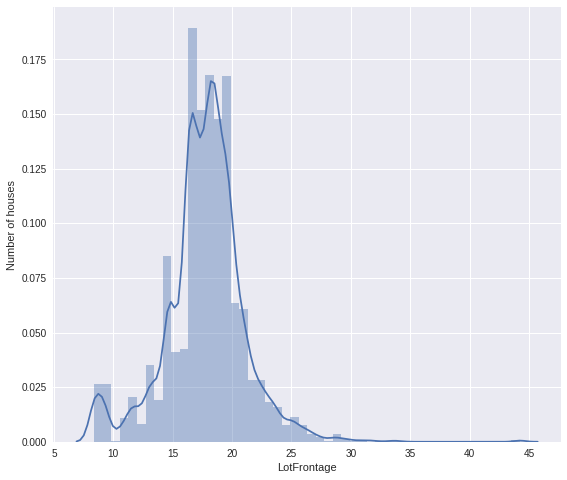

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


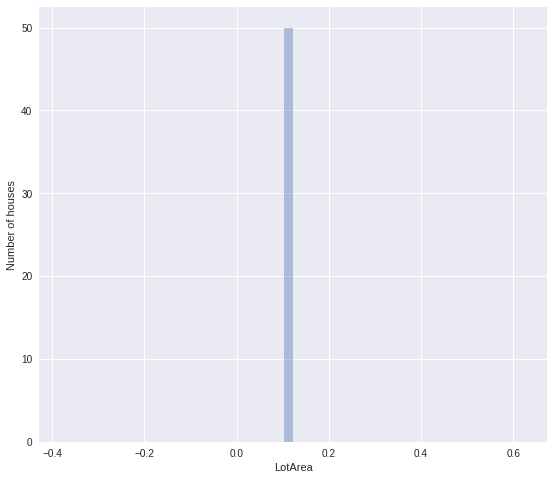

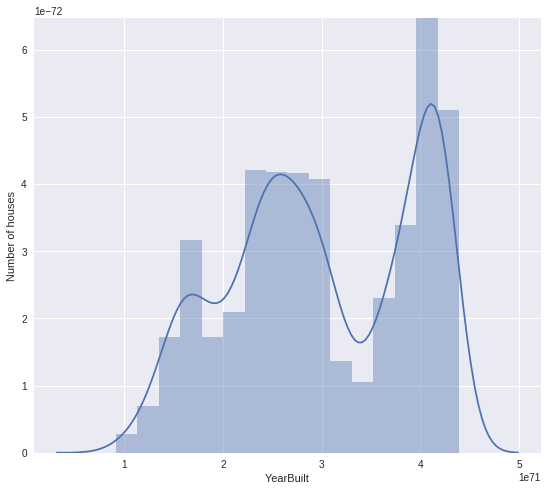

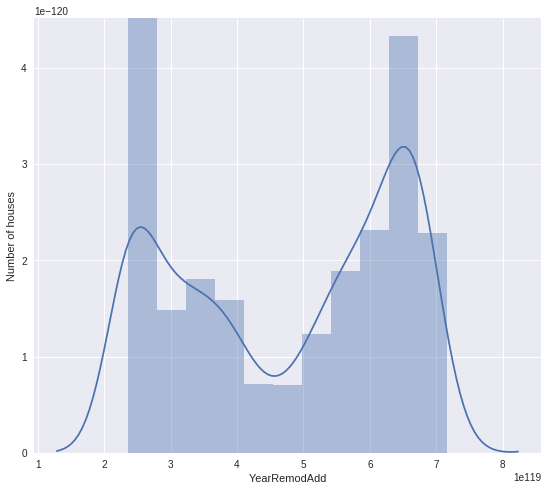

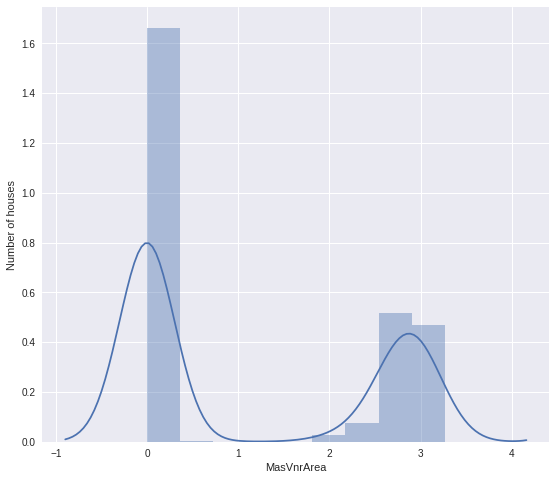

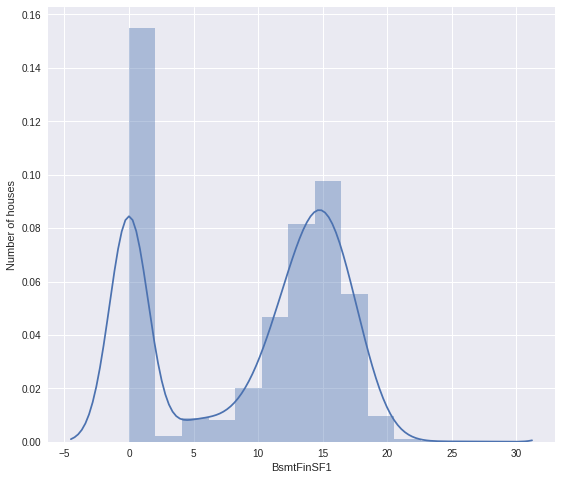

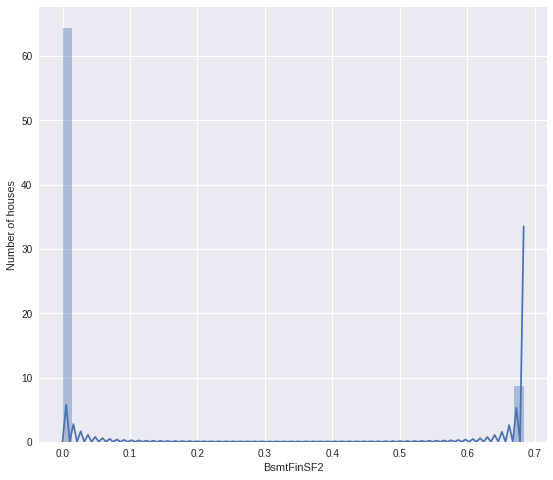

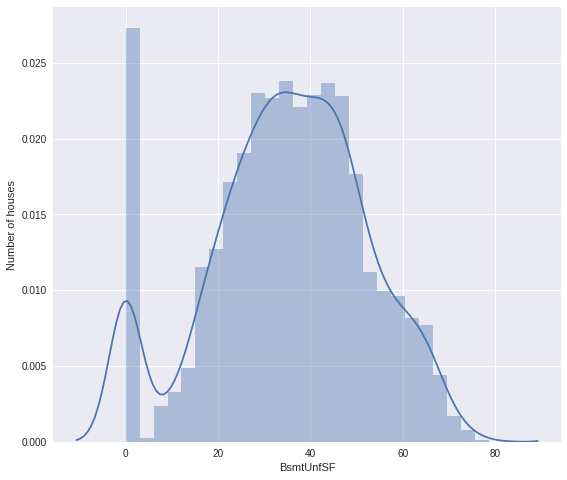

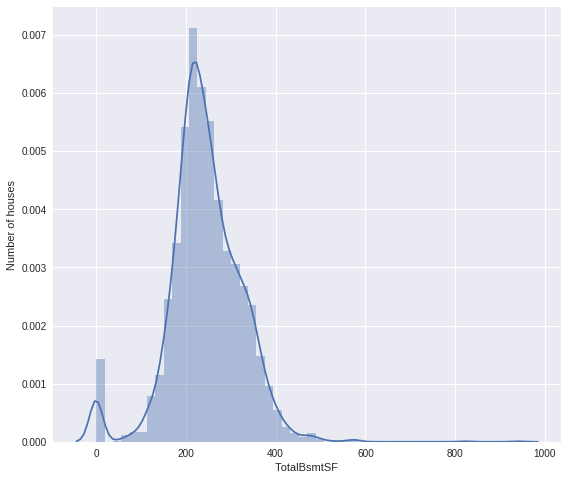

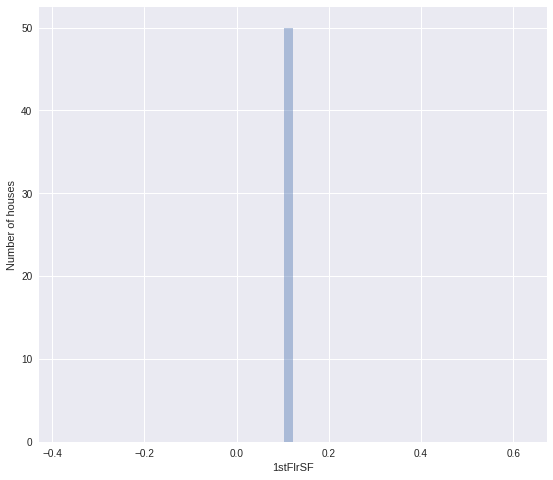

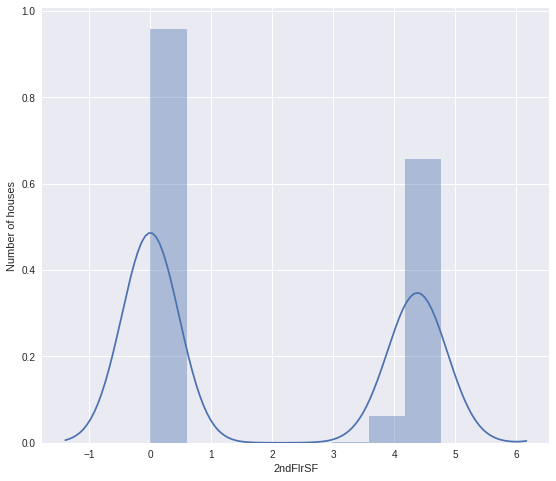

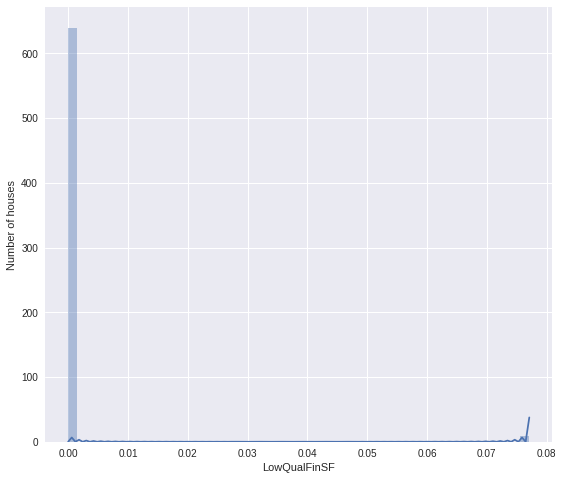

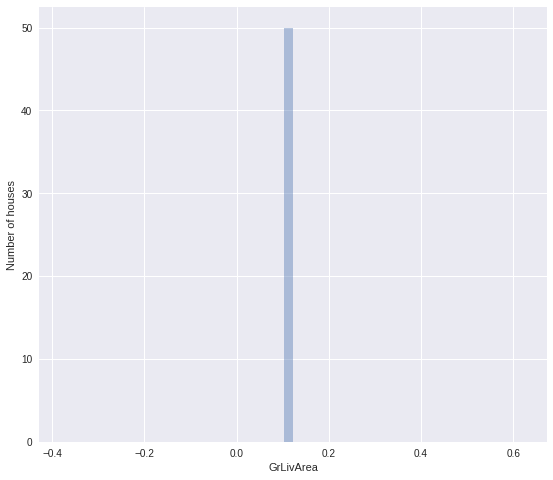

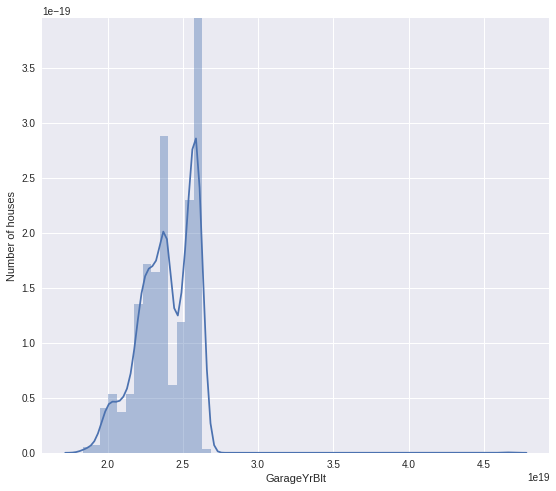

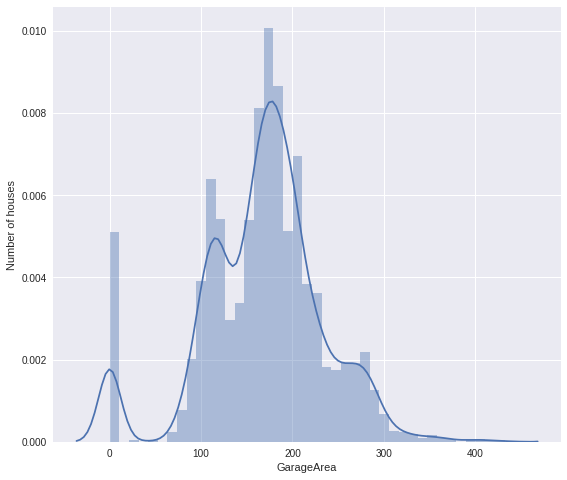

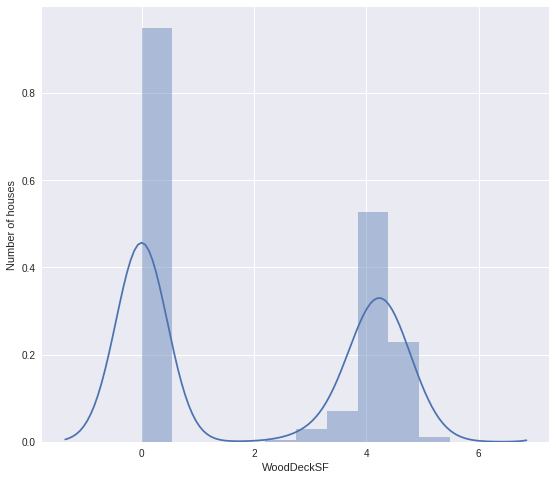

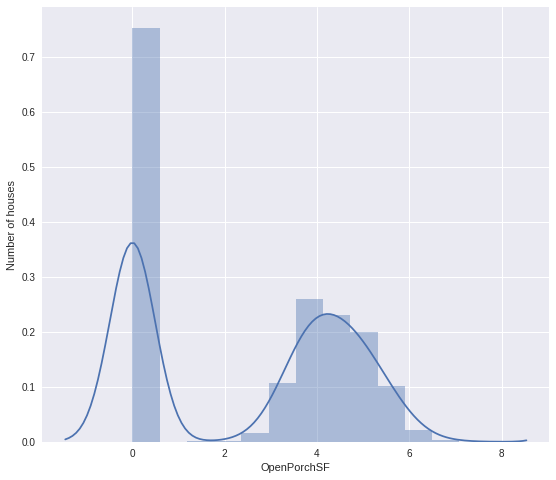

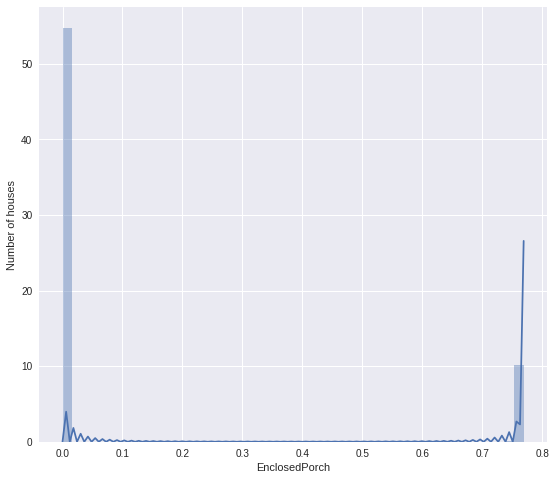

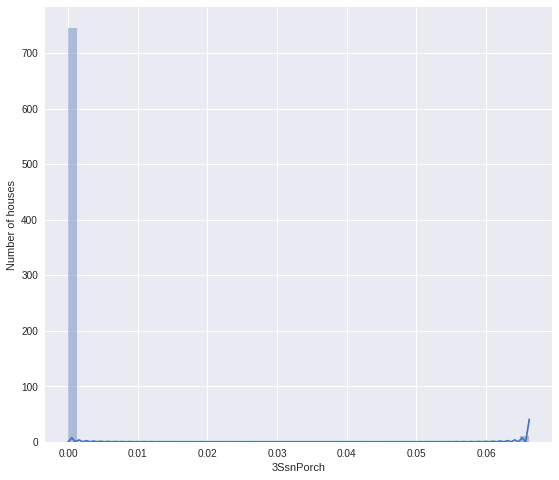

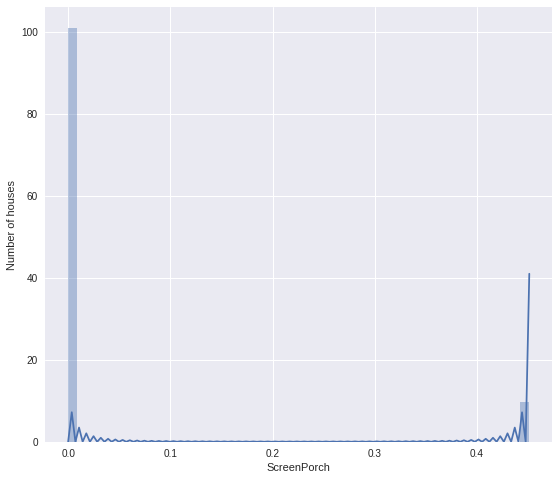

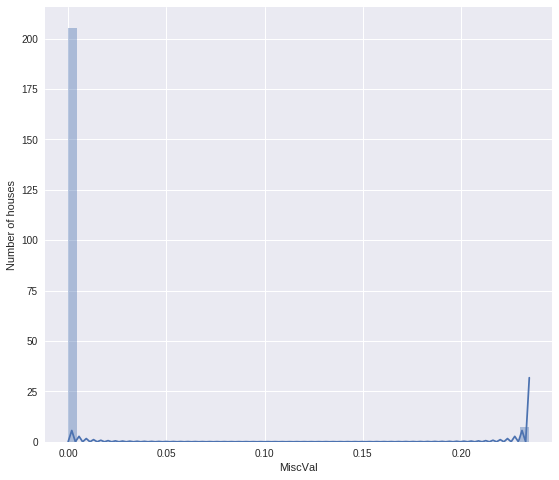

In [0]:
"""
    let's make histograms to get an idea of the distribution hopefully the transformation yielded 
    variables more "Gaussian" looking
""" 

for col in continuous:
    plt.figure(figsize=(20,8))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(all_data_df[col].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(col)

    plt.show()

The boxcox transformation worked for some of the variables, and of course it did not for some others. 
    Those for example where only one value was predominant could not be shaped into a Gaussian looking distribution.

Next section I will try to separate categorical features into two sub categories, If I can rank values of some categorical features then I will consider them as Ordinal categorical and rest other as Nominal categorical. As Machine Learning models take numerical values I need to convert categorical values into numeric values. I look into the description file to know the specific meaning of labels from all the categorical features. Then I will use label encoder to transform Ordinal categorical features and One Hot encoding for Nominal categorical features.

In [0]:
for col in categorical:
  print(all_data_df[col].value_counts())

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64
None    2721
Grvl     120
Pave      78
Name: Alley, dtype: int64
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64
Norm      2511
Feedr      164
Ar

In [0]:
"""
    From the description file I choose these 36 features as Ordinal categorical. So here I'm using label
    encoding for them
"""

categorical_ordinal = ('MSZoning', 'LotShape', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
                       'RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 
                       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
                      'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition')

for col in categorical_ordinal:
  encoder = LabelEncoder()
  encoder.fit(all_data_df[col])
  all_data_df[col] = encoder.transform(all_data_df[col])
all_data_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,17.218535,0.122411,Pave,None,3,Lvl,Inside,0,5,2,2,0,5,7,5,4.068260e+71,6.304326e+119,1,1,12,13,1,2.860781,2,4,2,2,4,3,2,15.051776,6,0.0,20.244814,213.170734,GasA,0,1,4,0.122411,4.433494,0.0,0.122411,1.0,0.0,2,1,3,1,2,8,6,0,3,1,2.577801e+19,2,2.0,193.670411,5,5,2,0.000000,4.308115,0.00000,0.0,0.0,0,3,4,None,0.0,2,2008,8,4
1,2,20,3,19.556671,0.122411,Pave,None,3,Lvl,FR2,0,24,1,2,0,2,6,8,3.014735e+71,3.829187e+119,1,1,8,8,2,0.000000,3,4,1,2,4,1,0,16.537189,6,0.0,27.997992,285.898536,GasA,0,1,4,0.122411,0.000000,0.0,0.122411,0.0,1.0,2,0,3,1,3,6,6,1,5,1,2.372541e+19,2,2.0,168.229053,5,5,2,4.566662,0.000000,0.00000,0.0,0.0,0,3,4,None,0.0,5,2007,8,4
2,3,60,3,17.703219,0.122411,Pave,None,0,Lvl,Inside,0,5,2,2,0,5,7,5,3.979492e+71,6.189721e+119,1,1,12,13,1,2.812112,2,4,2,2,4,2,2,13.479484,6,0.0,34.596653,225.122628,GasA,0,1,4,0.122411,4.439102,0.0,0.122411,1.0,0.0,2,1,3,1,2,6,6,1,5,1,2.562104e+19,2,2.0,210.546857,5,5,2,0.000000,3.911127,0.00000,0.0,0.0,0,3,4,None,0.0,9,2008,8,4
3,4,70,3,16.388996,0.122411,Pave,None,0,Lvl,Corner,0,6,2,2,0,5,7,5,1.508404e+71,3.424418e+119,1,1,13,15,2,0.000000,3,4,0,4,1,3,0,10.492175,6,0.0,38.545931,194.041385,GasA,2,1,4,0.122411,4.384063,0.0,0.122411,1.0,0.0,1,0,3,1,2,7,6,1,2,5,2.538709e+19,3,3.0,219.961755,5,5,2,0.000000,3.719447,0.76876,0.0,0.0,0,3,4,None,0.0,2,2006,8,0
4,5,60,3,20.147618,0.122411,Pave,None,0,Lvl,FR2,0,15,2,2,0,5,8,5,3.935804e+71,5.966561e+119,1,1,12,13,1,2.995086,2,4,2,2,4,0,2,14.725276,6,0.0,36.739846,265.627859,GasA,0,1,4,0.122411,4.516586,0.0,0.122411,1.0,0.0,2,1,4,1,2,9,6,1,5,1,2.554286e+19,2,3.0,271.953685,5,5,2,4.285706,4.652824,0.00000,0.0,0.0,0,3,4,None,0.0,12,2008,8,4


In [0]:
"""
    And I'm considering the rest 6 of them as Nominal categorical, So here I'm using
    One Hot encoding for them.
"""

categorical_nominal = ('Street', 'LandContour', 'LotConfig', 'Heating', 'MiscFeature', 'Alley')
for col in categorical_nominal:
  dummies = pd.get_dummies(all_data_df[col], prefix=col) 
  dummies = dummies.drop(dummies.columns[-1], axis=1)
  all_data_df = pd.concat([all_data_df, dummies], axis='columns')
  all_data_df = all_data_df.drop([col], axis='columns')

For data normalization I will use MinMaxScaler from sci-kit learn, which scales data between
    0 and 1. I'm using it because without scaling datas are in different range in different features,
    which leads more time to learn and sometimes model can't learn ar all. So that's why i'm using 
    data normalization and it's make faster the learning phase. And here I'm dropping the ID feature as it won't help me in decision making.

In [0]:
"""
    Feature Scaling...
"""

from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
all_data_minMaxScaled = all_data_df.copy()
all_data_minMaxScaled.drop(['Id'], axis=1, inplace=True)
all_data_minMaxScaled = minMaxScaler.fit_transform(all_data_minMaxScaled)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Skew is: 1.8828757597682129


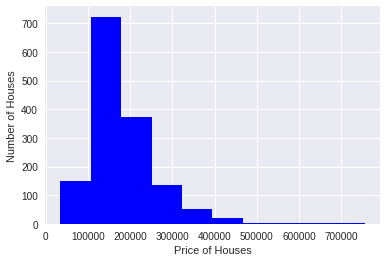

In [0]:
"""
    Now we will visualize the target feature 'SalePrice' and look into skewness of target.
"""
print ("Skew is:", y_train_df.skew())
plt.hist(y_train_df, color='blue')
plt.xlabel('Price of Houses')
plt.ylabel('Number of Houses')
plt.show()

We see that our target is skewed. We log transform this target to get better distribution and to reduce skewness.


Skew is: 0.12133506220520406


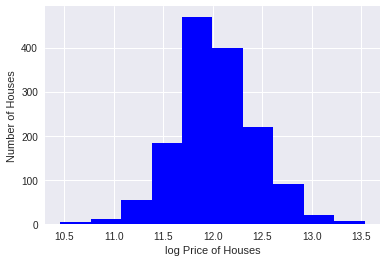

In [0]:
# log transforming the target feature

y_train_log_df = np.log(y_train_df)

print ("Skew is:", y_train_log_df.skew())
plt.hist(y_train_log_df, color='blue')
plt.xlabel('log Price of Houses')
plt.ylabel('Number of Houses')
plt.show()

Now we see that after log transformation skew value is near 0 which was previously almost 2, this is a great improvement. And in graph we see better distribution.

Scaled features are ready and we have normalized target too. Now we will split up training and testing data as we combined them previously. and then we will design our Neural Network model for evaluration.

# Deep Neural Network model building and training

In [0]:
train_data_minMaxScaled = all_data_minMaxScaled[:nOftrainSample]
test_data_minMaxScaled = all_data_minMaxScaled[nOftrainSample:]

In [0]:
# reshaping target value to fit into tensor.

Y_train = y_train_log_df.reshape((1460, 1))
print(Y_train.shape)


(1460, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [0]:
# assigning training and testing data in two separate variables for further use in Neural Net model.

test_np_ann_data = test_data_minMaxScaled

X_train = train_data_minMaxScaled

As we've completed our Data preprocessing and Feature engineering, now we will design our Neural Network model. 


---


First I will go with four hidden layer and it's an arbitrary choice, as after Label encoding and One Hot encoding our total number of feature is 91 so input layer will have 91 neurons.
Output layer with 1 neuron as we are aiming to design this model for regression. 1st hidden layer with 100 neurons, 2nd with 50, 3rd with 25 and 4th with 12 neurons have been chosen.

I will use AdamOptimizer as optimizer and reduce_mean as cost function. I will experiment with other combinations. So below code will be little bit changed as below code will be my best Neural Net. 

I will try to explain next how I have got my best performance.

I took whole training data for training phase, I didn't separate validation data from train file. Here in each epoch I ran whole training data for training, didn't split them into batches. 



In [0]:
# number of neurons in each layer
input_num_units = 91
hidden_num_units_1 = 20
hidden_num_units_2 = 8
output_num_units = 1

epochs = 3000

loss_list = []

# define placeholders
x_train = tf.placeholder(tf.float32, [None, input_num_units])
y_train = tf.placeholder(tf.float32, [None, output_num_units])

### define weights and biases of the neural network  
weights = {
    'hidden_1': tf.Variable(tf.truncated_normal ([input_num_units, hidden_num_units_1])),
    'hidden_2': tf.Variable(tf.truncated_normal ([hidden_num_units_1, hidden_num_units_2])),
    'output': tf.Variable(tf.random_uniform ([hidden_num_units_2, output_num_units]))
}

biases = {
    'hidden_1': tf.Variable(tf.truncated_normal ([hidden_num_units_1])),
    'hidden_2': tf.Variable(tf.random_uniform ([hidden_num_units_2])),
    'output': tf.Variable(tf.random_uniform ([output_num_units]))
}

#Now create our neural networks computational graph
hidden_layer_1 = tf.add(tf.matmul(x_train, weights['hidden_1']), biases['hidden_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)

hidden_layer_2 = tf.add(tf.matmul(hidden_layer_1, weights['hidden_2']), biases['hidden_2'])
hidden_layer_2 = tf.nn.relu(hidden_layer_2)

output_layer = tf.add(tf.matmul(hidden_layer_2, weights['output']), biases['output'])

#Also, we need to define cost of our neural network
cost = tf.reduce_mean((Y_train - output_layer)**2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.14)
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

ses = tf.Session()
ses.run(init)

for i in range(epochs):
  _,loss_value = ses.run((train, cost), feed_dict = {x_train: X_train, y_train: Y_train})
  if((i+1)%25 == 0):
    loss_list.append(np.sqrt(loss_value))
    print('epoch : #', i+1, 'cost(rmse) :', np.sqrt(loss_value))
  
output_value = ses.run(output_layer, feed_dict = {x_train: test_np_ann_data})

ses.close()

epoch : # 25 cost(rmse) : 1.5150741
epoch : # 50 cost(rmse) : 0.769996
epoch : # 75 cost(rmse) : 0.70303553
epoch : # 100 cost(rmse) : 0.6533973
epoch : # 125 cost(rmse) : 0.61341137
epoch : # 150 cost(rmse) : 0.58255345
epoch : # 175 cost(rmse) : 0.5568103
epoch : # 200 cost(rmse) : 0.5346294
epoch : # 225 cost(rmse) : 0.5151358
epoch : # 250 cost(rmse) : 0.4977234
epoch : # 275 cost(rmse) : 0.48195583
epoch : # 300 cost(rmse) : 0.46751365
epoch : # 325 cost(rmse) : 0.45416057
epoch : # 350 cost(rmse) : 0.44172043
epoch : # 375 cost(rmse) : 0.43006146
epoch : # 400 cost(rmse) : 0.4190852
epoch : # 425 cost(rmse) : 0.4087164
epoch : # 450 cost(rmse) : 0.39889774
epoch : # 475 cost(rmse) : 0.3895836
epoch : # 500 cost(rmse) : 0.3807362
epoch : # 525 cost(rmse) : 0.37232307
epoch : # 550 cost(rmse) : 0.3643148
epoch : # 575 cost(rmse) : 0.35668236
epoch : # 600 cost(rmse) : 0.34939831
epoch : # 625 cost(rmse) : 0.34243467
epoch : # 650 cost(rmse) : 0.33576405
epoch : # 675 cost(rmse) : 0

In [0]:
#plotting cost through iterations

plt.plot(range(len(loss_list)), loss_list)
plt.xlabel('Epochs ')
plt.ylabel('RMSE Loss')
plt.title("Loss per Epoch Graph(RMSE)")
plt.xlim(0, len(loss_list) + 10)
plt.ylim(-.5, np.max(loss_list))
plt.rcParams['figure.figsize'] = [16, 6]
plt.show()

# Evaluation, Hyper parameter tuning and RESULTS

In my first kaggle submission **RMSE was 0.49457**. Network was long(4 hidden layer). then I tried to tweak hyperparameters and reduce hidden layer. 

---


Then for the following cofiguration I've got **Training RMSE: 0.36630806** and in **kaggle RMSE was: 0.36402**. The configuration was : 
- 3 hidden layers with (50 -> 20 -> 8) neurons. 
- epoch: 2000
- AdamOptimizer with learning rate 0.01
- reduce_mean as cost function for squared error 
- below showing the error graph 


In [0]:
from IPython.display import Image
uploaded = files.upload()

Saving 1.PNG to 1.PNG


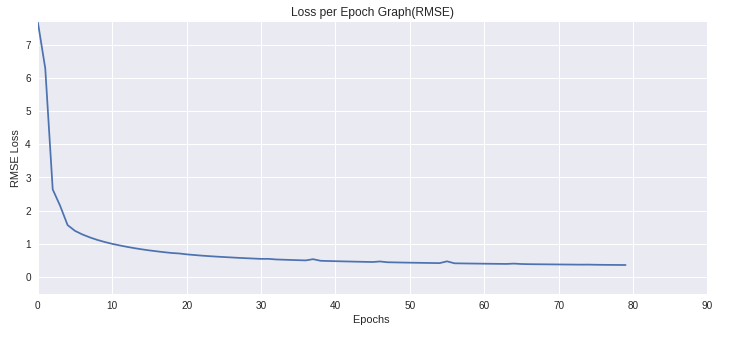

In [0]:
Image('1.PNG', width = 800)

As reduced hidden layer and reducing in number of neurons in hidden layer gave better performance I set to reduce hidden neurons more, then after few try I got significant improvement in training accuracy. Training **RMSE was: 0.1359444**. As I reduced hidden neurons I thought I need to increase training iteration or epoch, **I incresed epoch 700 and set to 2700**  and as I increased the **learning rate to 0.1** from 0.01, other wise learning won't get into minima as I increased epoch. Then I got kaggle **RMSE:0.15235**. Configuration was like : 


*  3 hidden layers with (35 -> 15 -> 4) neurons.
*  epoch: 2700
*  AdamOptimizer with learning rate 0.1
*  reduce_mean as cost function for squared error
*  Cost graph was like: 

In [0]:
uploaded = files.upload()

Saving 2.PNG to 2.PNG


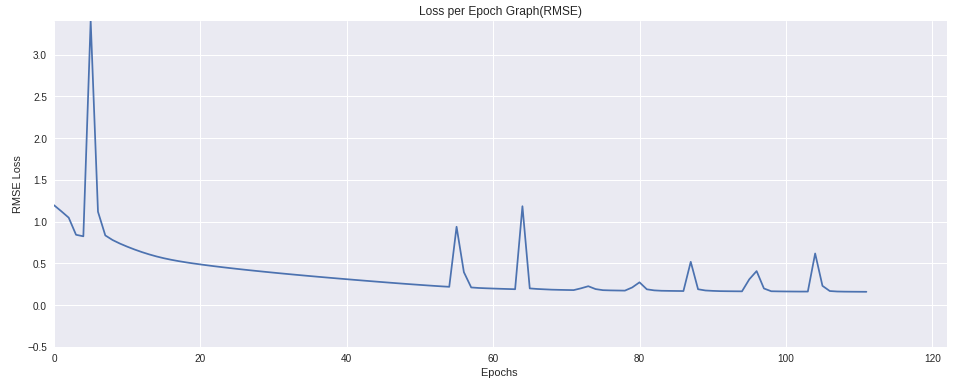

In [0]:
Image('2.PNG', width = 1000)

As this gave better performance loss curve was downward I tried to increase training epoch and increase learning rate. Previously two hidden layers weight variable was declared with tf.truncated_normal and another one hidden and output layers weight variable was declared with tf.random_uniform, in this I changed 3rd hidden layer weight variable with tf.truncated_normal. Then I got slight improvement. **Layer structure was same, epoch was: 3500, learning rate was 1.4, reduce_mean as cost function. I got Training RMSE: 0.140757 and kaggle RMSE: 0.14710**. In between I also tried with GradientDescentOptimizer and AdagradOptimizer but they didn't gave me better output. Used **ReLU** as activation function for hidden layers, as **ReLU** is being cosidered as **state of the art** now a days for hidden layers in Deep Learning.

---

Finally I reduced another hidden layer and epoch set to 3000 and learning rate as 0.14. Then I got slight improvement in training RMSE and kaggle RMSE. Got **Training RMSE: 0.13833138** and **Kaggle RMSE: 0.14416** Configuration was like :


*   2 hidden layers with (20 -> 8) neurons.
*   epoch: 3000
*   AdamOptimizer with learning rate 0.14
*   reduce_mean as cost function for squared error
*   Cost graph was like:

In [0]:
uploaded = files.upload()

Saving 3.PNG to 3.PNG


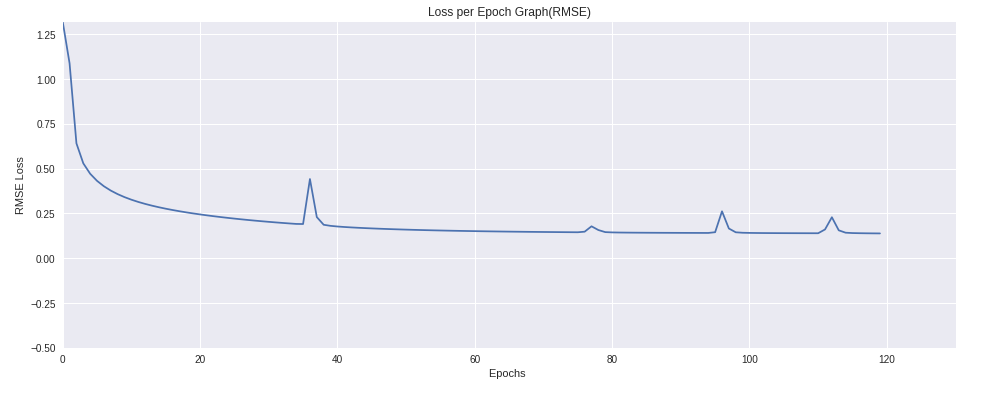

In [0]:
Image('3.PNG', width = 1000)

Below cell I'll show screenshot of my kaggle submissions. And here is my all submission url : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submissions?sortBy=date&group=all&page=1

In [0]:
uploaded = files.upload()

Saving ANN_2.PNG to ANN_2.PNG


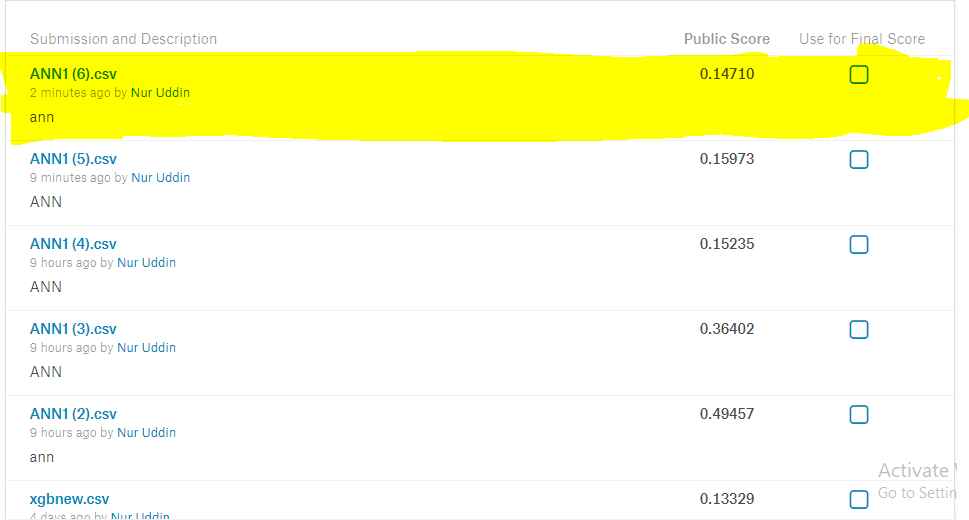

In [0]:
# This image contains earlier submissions.
Image('ANN.PNG', width = 800)

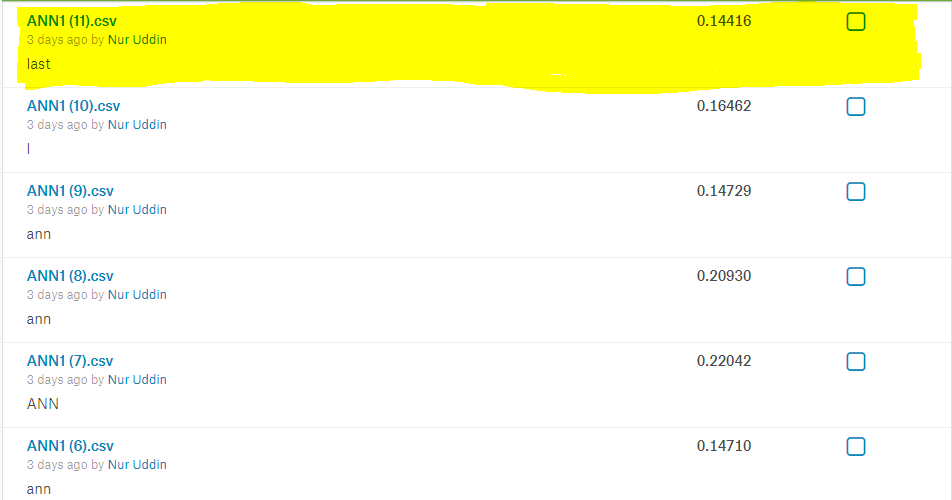

In [0]:
Image('ANN_2.PNG', width = 800)

# Conclusion


*   During the analysis we investigated, cleaned and engineered train and test data of this House Price problem. We did handle null values carefully, corrected skewness of continuous features, encoded categorical data, deleted feature that is not relevant, normalized whole dataset for better performance. 
*   There are lot more thing that can be done for better performance and improvement of the features before using them in model. We used box cox transformation for all continuous features, but it could be done only for those features that benifit from it, then apply other technique on rest of the features, for example dicretisation. We didn't handle outliers, outliers handle can improve the model performance.
*   We just deleted one feature. There could be done anlysis on similar features then keep most relevant one respect to target and could be dropped rest features.
*   We pre-processed train and test data together, in real world scenario we have to pre-process only train data, because we may not have test data at the time of model building and training.
*   We did not splitted the data into train and validation set, in real world scenario we have to do that to assess our model. We didn't split into batches during training, as this data set is small this didn't gave bad result. In real world scenario we have to split into batches for avoid overfitting during training. We could use grid search or other technique for hyper parameter tuning as deep neural network has so many tunable parameter, this will make faster the process. 



# References
Throughout the process I followed below links. Used stackoverflow, scikit learn, pandas, tensorflow documentation.


*   https://www.dataquest.io/blog/kaggle-getting-started/
*   https://www.kaggle.com/solegalli/feature-engineering-for-house-price-modelling
*   https://www.kaggle.com/mohitguptaomg/4-layer-dense-neural-net-using-tensorflow
*   https://www.analyticsvidhya.com/blog/2016/10/an-introduction-to-implementing-neural-networks-using-tensorflow/

